In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

In [43]:
df = pd.read_csv('electric-production.csv', parse_dates=True, index_col='DATE')

In [44]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [45]:
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [46]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

<Axes: xlabel='DATE'>

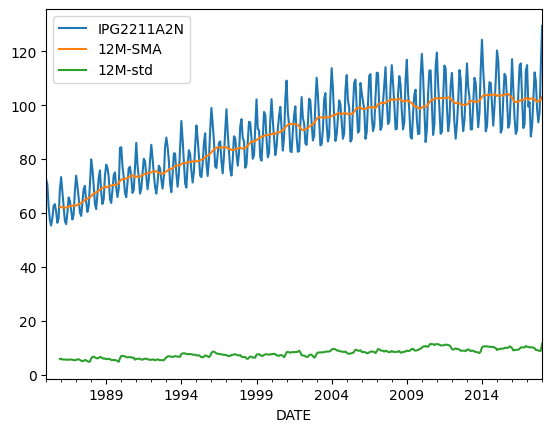

In [47]:
df['12M-SMA'] = df['IPG2211A2N'].rolling(window=12).mean()
df['12M-std'] = df['IPG2211A2N'].rolling(window=12).std()

df.plot()


In [48]:
#Проведем тест на стационарность ряда
from statsmodels.tsa.stattools import adfuller

adfuller_result = adfuller(df['IPG2211A2N'])

print('ADF Statistic:', adfuller_result[0])
print('p-value:', adfuller_result[1])
print('Critical Values:', adfuller_result[4])

ADF Statistic: -2.25699035004725
p-value: 0.18621469116586592
Critical Values: {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}


P value больше 0,05 то гипотеза о присутствии единичного корня не отвергается, ряд не стационарен

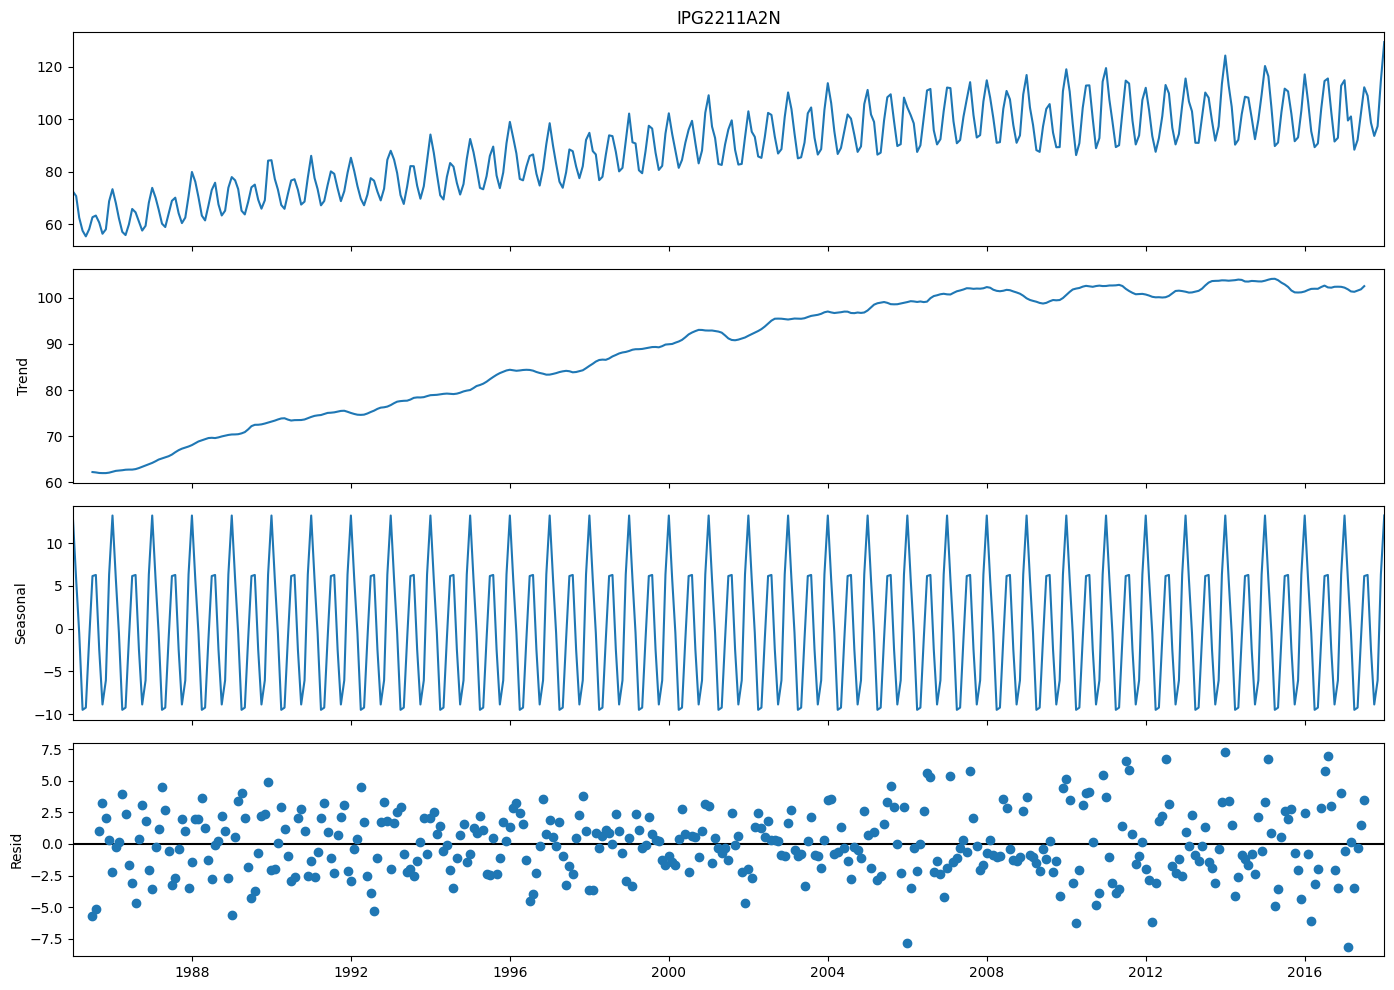

In [49]:
#Сезонная декомпозиция
from statsmodels.tsa.seasonal import seasonal_decompose # оценка сезонности


ssn= seasonal_decompose(df["IPG2211A2N"], model="add")
fig = ssn.plot()
fig.set_size_inches((14, 10))
fig.tight_layout()
plt.show()

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

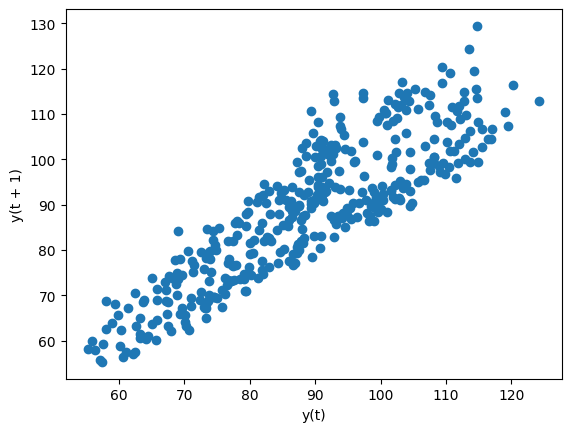

In [50]:
from pandas.plotting import lag_plot 

lag_plot(df['IPG2211A2N'])

Достаточно сильная корреляция следующего значения от предыдущего

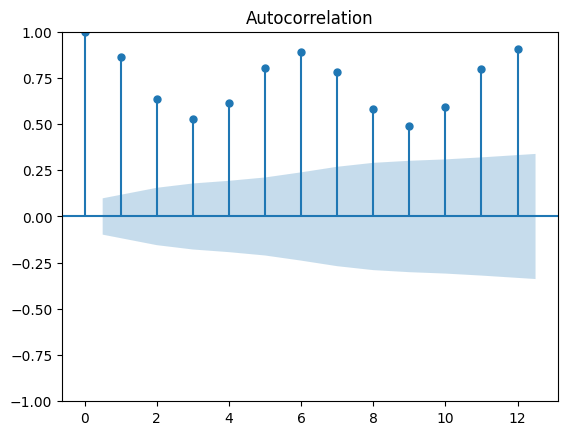

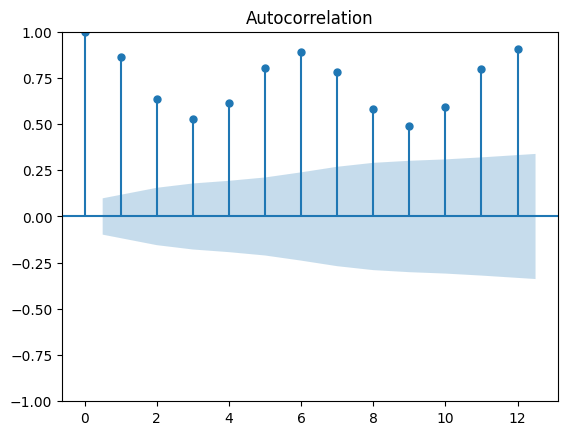

In [51]:
#график ACF
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['IPG2211A2N'], lags=12)

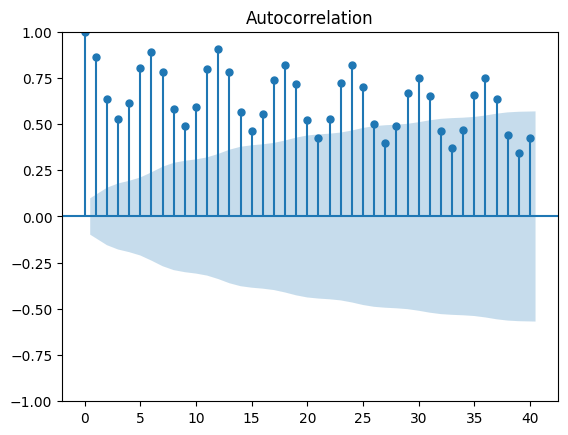

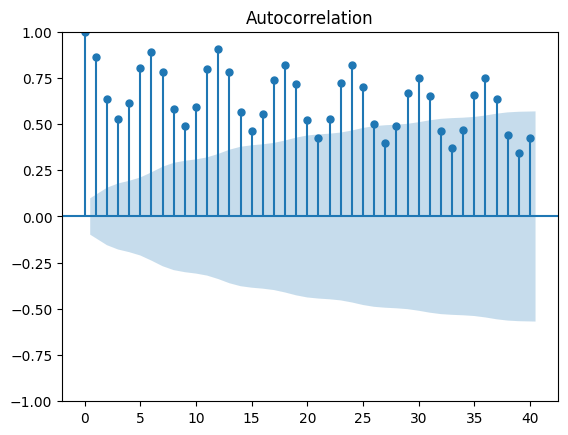

In [52]:
plot_acf(df['IPG2211A2N'], lags=40)

Явно выражена сезонность по 6 и 12 месяцев

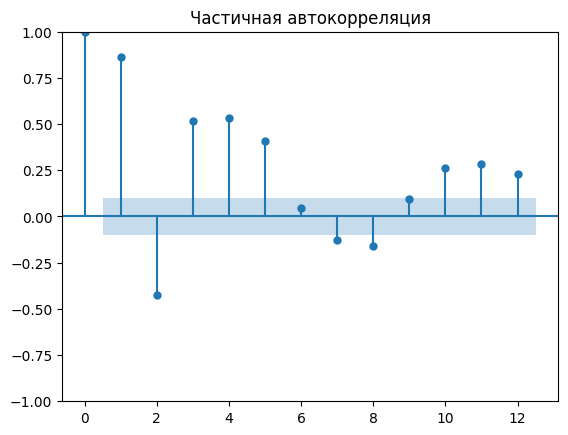

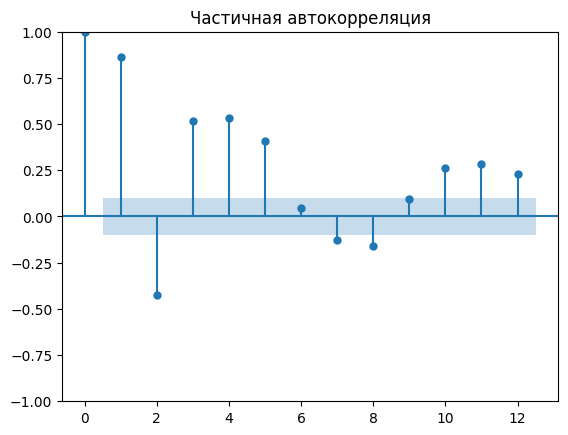

In [53]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['IPG2211A2N'], lags=12, title='Частичная автокорреляция')


Цикличность на графике частичной автокорреляции указывает на сезонность

<Axes: xlabel='DATE'>

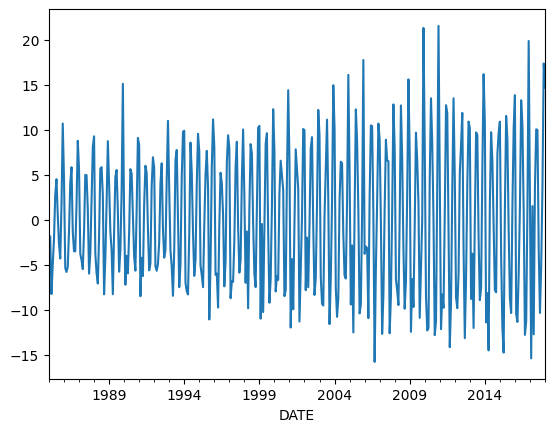

In [54]:
#дифференцируем ряд для приведения к стационарному виду
from statsmodels.tsa.statespace.tools import diff

df['diff_1'] = diff(df['IPG2211A2N'], k_diff=1)
df['diff_1'].plot()

In [55]:
#Тестируем на стационарность тестом ДФуллера
adfuller_result = adfuller(df["diff_1"].dropna(), autolag='AIC')

print('ADF Statistic:', adfuller_result[0])
print('p-value:', adfuller_result[1])
print('Critical Values:', adfuller_result[4])

ADF Statistic: -7.104890882267312
p-value: 4.0777865655394095e-10
Critical Values: {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}


P-value меньше 0,05 данные стационарные

<Axes: xlabel='DATE'>

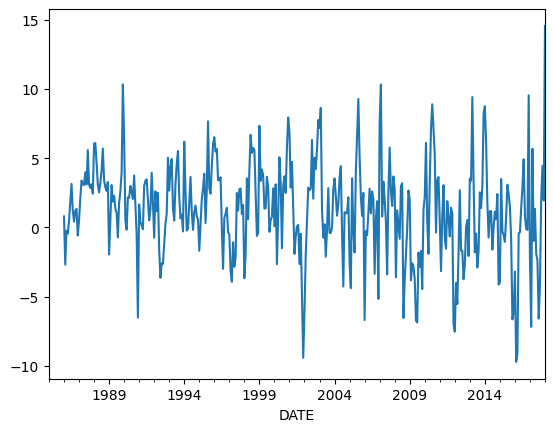

In [56]:
# стационарность после сезонной разности

df["diff_season"]= diff(df["IPG2211A2N"], k_diff=0,k_seasonal_diff= 1,seasonal_periods= 12)
df["diff_season"].plot()

In [57]:
adfuller_result = adfuller(df["diff_season"].dropna(), autolag='AIC')

print('ADF Statistic:', adfuller_result[0])
print('p-value:', adfuller_result[1])
print('Critical Values:', adfuller_result[4])

ADF Statistic: -5.673482023381753
p-value: 8.812644938089282e-07
Critical Values: {'1%': -3.4480516066132636, '5%': -2.869340997473759, '10%': -2.5709257824604}


Данные стационарны

In [58]:
TEST_SIZE = 12

train= df.iloc[:len(df)-TEST_SIZE]
test= df.iloc[len(df)-TEST_SIZE:]

print(len(train), len(test))

385 12


In [59]:
print(train.head())

            IPG2211A2N  12M-SMA  12M-std  diff_1  diff_season
DATE                                                         
1985-01-01     72.5052      NaN      NaN     NaN          NaN
1985-02-01     70.6720      NaN      NaN -1.8332          NaN
1985-03-01     62.4502      NaN      NaN -8.2218          NaN
1985-04-01     57.4714      NaN      NaN -4.9788          NaN
1985-05-01     55.3151      NaN      NaN -2.1563          NaN


In [60]:
#Подберем параметры для модели ARIMA
from pmdarima import auto_arima

auto_arima_results= auto_arima(train["IPG2211A2N"],
           start_p=0,
           start_q=0,
           max_p=5,
           max_q=5,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2657.357, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2599.753, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2531.251, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2655.436, Time=0.02 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2531.973, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2433.235, Time=0.16 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2400.984, Time=0.18 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2353.950, Time=0.19 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2353.710, Time=0.19 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2336.712, Time=0.20 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2337.090, Time=0.31 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2263.899, Time=0.31 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2253.412, Time=0.46 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1976.275, Time=0.87 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1971.845, Time=0.62 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2007.706, Time=0.54 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1983.340, Time=0.73 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=1971.301, Time=0.87 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=1970.997, Time=0.87 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1963.523, Time=0.80 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1973.719, Time=0.64 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 12.578 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  385
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -971.762
Date:                Sun, 06 Apr 2025   AIC                           1963.523
Time:                        12:23:52   BIC                           2003.030
Sample:                    01-01-1985   HQIC                          1979.193
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0701      0.018      3.820      0.000       0.034       0.106
ar.L1          0.6873      0.147      4.662      0.000       0.398       0.976
ar.L2         -0.0251      0.236     -0.107      0.915      -0.487       0.437
ar.L3         -0.9725      0.235     -4.134      0.000      -1.434      -0.511
ar.L4          0.6602      0.111      5.969      0.000       0.443       0.877
ma.L1         -1.0100      0.138     -7.332      0.000      -1.280      -0.740
ma.L2         -0.0120      0.267     -0.045      0.964      -0.536       0.512
ma.L3          1.0061      0.260      3.866      0.000       0.496       1.516
ma.L4         -0.9081      0.123     -7.401      0.000      -1.149      -0.668
sigma2         8.9781      0.637     14.084      0.000       7.729      10.227
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.05
Prob(Q):                              1.00   Prob(JB):                         0.08
Heteroskedasticity (H):               1.69   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

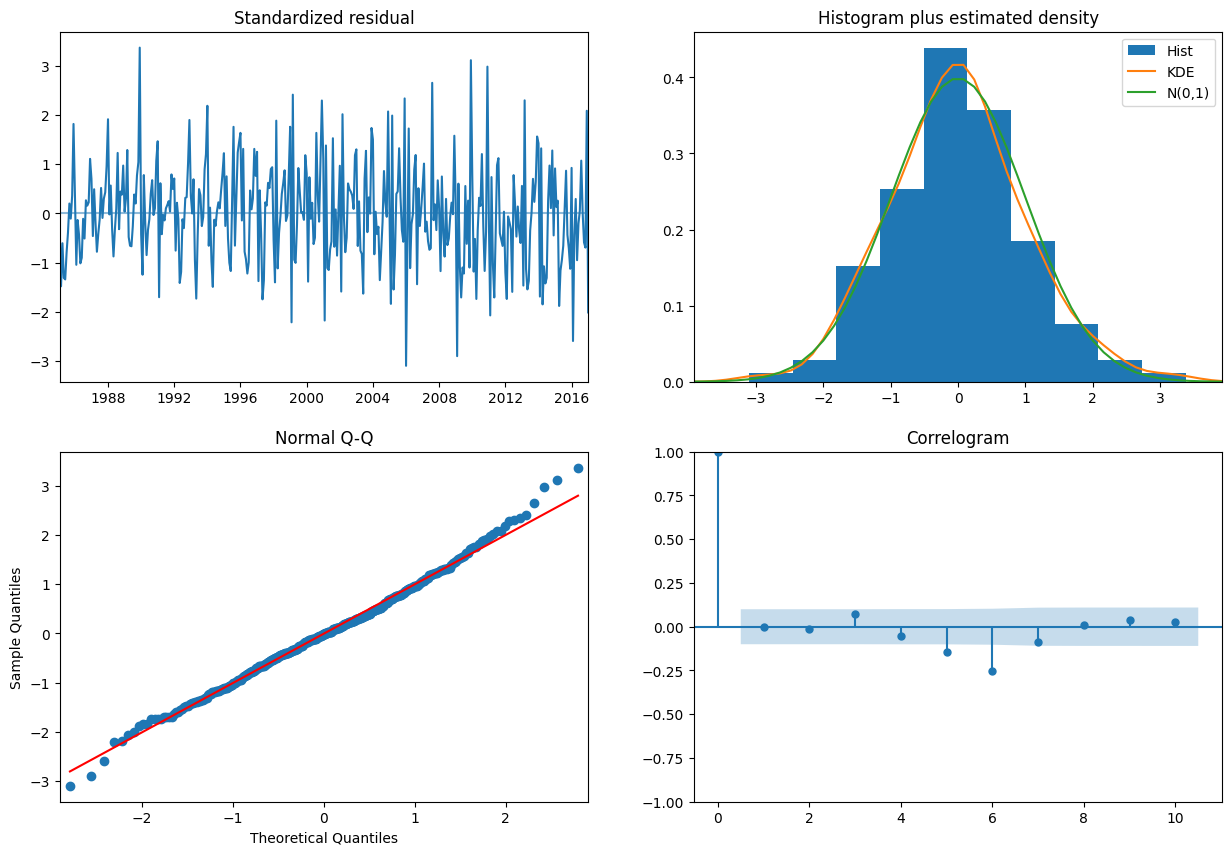

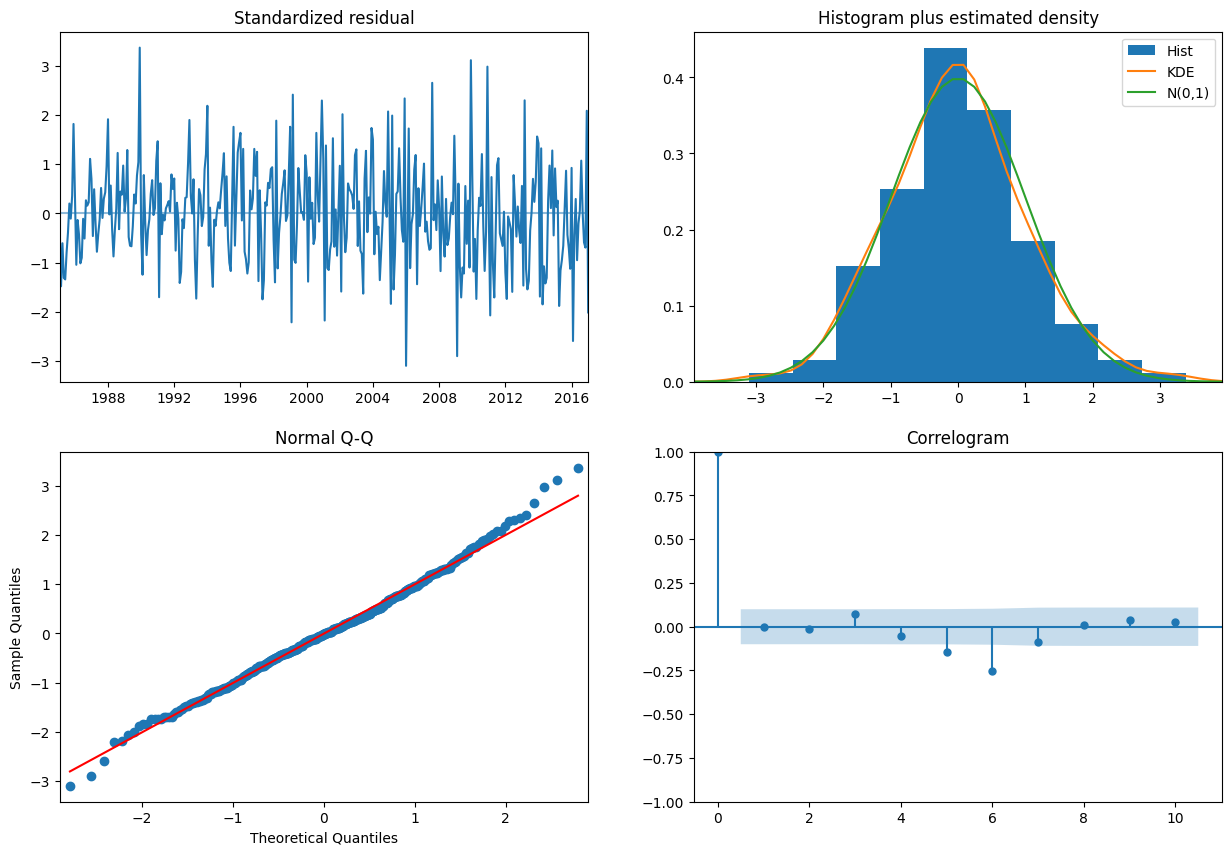

In [61]:
auto_arima_results.plot_diagnostics(figsize=(15,10))

In [62]:
# тренируем модель ARIMA
from statsmodels.tsa.arima.model import ARIMA

arima_model=ARIMA(train["IPG2211A2N"], order= auto_arima_results.order, freq=train.index.inferred_freq)
arima_model_fit=arima_model.fit()

d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
#проверяем что остатки модели нормально распределены
from scipy.stats import normaltest

normaltest(arima_model_fit.resid)

NormaltestResult(statistic=627.5954883322684, pvalue=5.240482498970595e-137)

pvalue меньше 0,05 значит остатки нормально распределены

d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'Актуальные данные и прогноз'}, xlabel='DATE'>

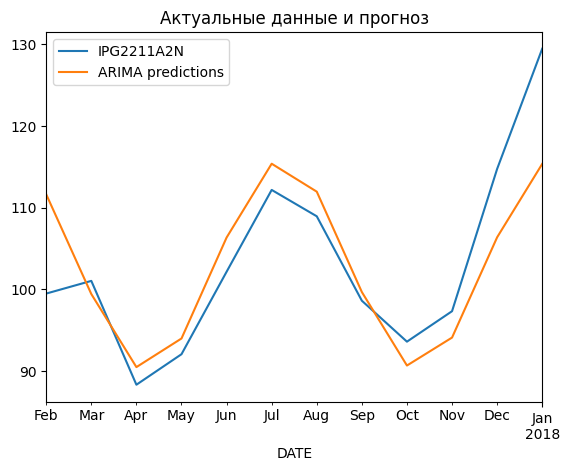

In [64]:
start= len(train)
end= len(train) + len(test) -1

pred=arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

test["IPG2211A2N"].plot(title='Актуальные данные и прогноз', legend=True)

pred.plot(legend=True)

In [65]:
#Оценка модели

from sklearn.metrics import mean_squared_error # метрика качества MSE
from statsmodels.tools.eval_measures import rmse  # метрика качества Квадратный корень из MSE


mse_arima = mean_squared_error(test["IPG2211A2N"],pred)
rmse_arima = rmse(test["IPG2211A2N"], pred)

print(f"RMSE= {rmse_arima} \n")
print(f"MSE= {mse}")

RMSE= 6.34101092033455 

MSE= 20.14190657606586


In [66]:
#Модель SARIMA
# Определение сезона 12 для ежегодной сезонности
seasonal_period = 12

auto_arima_results= auto_arima(train["IPG2211A2N"],
           start_p=0,
           start_q=0,
           max_p=5,
           max_q=5,
           m=12,
           d=None,
           seasonal=True,
           trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1866.130, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2657.357, Time=0.02 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.23 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2308.651, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2655.436, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2364.393, Time=0.13 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.12 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1866.597, Time=1.07 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1865.731, Time=1.62 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2247.245, Time=0.46 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.65 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1855.696, Time=1.56 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2243.105, Time=0.49 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1855.630, Time=0.58 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2339.765, Time=0.15 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1856.410, Time=1.30 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2599.753, Time=0.05 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.65 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=1856.892, Time=2.05 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1834.036, Time=0.64 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2211.365, Time=0.18 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.27 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1833.351, Time=1.64 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.71 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[12] intercept   : AIC=1831.980, Time=2.38 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=1831.885, Time=1.91 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=2163.015, Time=0.45 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,2)[12] intercept   : AIC=1827.862, Time=2.12 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,2)[12] intercept   : AIC=2077.987, Time=0.78 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=1829.953, Time=0.67 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[12] intercept   : AIC=1826.768, Time=2.55 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,1)[12] intercept   : AIC=1829.474, Time=2.07 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,2)[12] intercept   : AIC=1816.390, Time=2.92 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[12] intercept   : AIC=1819.228, Time=2.13 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,1)[12] intercept   : AIC=1817.915, Time=2.51 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[12] intercept   : AIC=1818.745, Time=0.99 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,2)[12] intercept   : AIC=1803.206, Time=3.28 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,2)[12] intercept   : AIC=1810.297, Time=2.48 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,1)[12] intercept   : AIC=1805.904, Time=3.13 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,1)[12] intercept   : AIC=1806.172, Time=1.47 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=3.55 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.86 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,2)[12]             : AIC=1800.950, Time=3.06 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,2)[12]             : AIC=1802.560, Time=1.54 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,1)[12]             : AIC=1803.921, Time=1.79 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,1)[12]             : AIC=1804.185, Time=0.88 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,2)[12]             : AIC=1813.906, Time=2.65 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,2)[12]             : AIC=1782.473, Time=3.36 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,2)[12]             : AIC=1783.747, Time=2.51 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,1)[12]             : AIC=1784.752, Time=2.87 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[12]             : AIC=1784.437, Time=1.29 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,2)[12]             : AIC=1780.661, Time=2.64 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,2)[12]             : AIC=1782.062, Time=2.17 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,1)[12]             : AIC=1783.025, Time=1.96 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,1)[12]             : AIC=1782.596, Time=0.87 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[12]             : AIC=1779.118, Time=2.01 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[12]             : AIC=1780.816, Time=1.76 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,1)[12]             : AIC=1781.883, Time=1.34 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[12]             : AIC=1781.538, Time=0.67 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12]             : AIC=1777.373, Time=2.23 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,2)[12]             : AIC=1779.337, Time=1.29 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,1)[12]             : AIC=1780.262, Time=1.38 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12]             : AIC=1779.716, Time=0.57 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12]             : AIC=inf, Time=1.82 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[12]             : AIC=1829.714, Time=1.78 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[12]             : AIC=inf, Time=2.20 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12]             : AIC=1854.663, Time=1.91 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[12]             : AIC=1777.040, Time=2.13 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,2)[12]             : AIC=1778.813, Time=1.46 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,1)[12]             : AIC=1779.824, Time=1.22 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12]             : AIC=1779.427, Time=0.49 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,2)[12]             : AIC=1786.550, Time=2.22 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,2)[12]             : AIC=1783.521, Time=2.68 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,2)[12]             : AIC=1837.967, Time=1.82 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(2,0,2)[12]             : AIC=1778.870, Time=2.81 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[12]             : AIC=inf, Time=3.18 sec


d:\projects\ml algorithms\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=2.43 sec

Best model:  ARIMA(1,1,2)(2,0,2)[12]          
Total fit time: 121.687 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  385
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -880.520
Date:                            Sun, 06 Apr 2025   AIC                           1777.040
Time:                                    12:25:55   BIC                           1808.645
Sample:                                01-01-1985   HQIC                          1789.576
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3588      0.101      3.560      0.000       0.161       0.556
ma.L1         -0.7395      0.101     -7.289      0.000      -0.938      -0.541
ma.L2         -0.1973      0.089     -2.208      0.027      -0.372      -0.022
ar.S.L12       0.5152      0.242      2.132      0.033       0.041       0.989
ar.S.L24       0.4786      0.241      1.990      0.047       0.007       0.950
ma.S.L12      -0.1740      0.233     -0.747      0.455      -0.631       0.283
ma.S.L24      -0.4737      0.164     -2.885      0.004      -0.795      -0.152
sigma2         5.2622      0.359     14.646      0.000       4.558       5.966
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.17
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.66   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
best_order = auto_arima_results.order
best_seasonal_order = auto_arima_results.seasonal_order

print(best_order, best_seasonal_order)

(1, 1, 2) (2, 0, 2, 12)


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train['IPG2211A2N'], order=best_order, seasonal_order=best_seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\base\model.py:607: Conve

In [69]:
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

d:\projects\ml algorithms\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='DATE'>

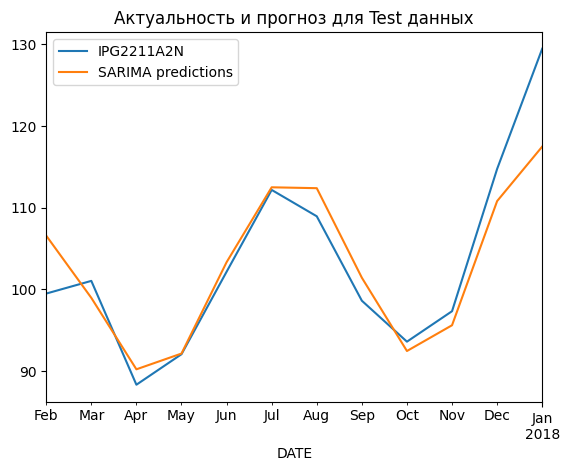

In [70]:
title= "Актуальность и прогноз для Test данных"
test["IPG2211A2N"].plot(title= title, legend=True)
pred.plot(legend=True)

In [71]:
# оценим модель
mse_sarima= mean_squared_error(test["IPG2211A2N"],pred)
rmse_sarima= rmse(test["IPG2211A2N"], pred)

print(f"RMSE= {rmse_sarima} \n")
print(f"MSE= {mse}")

RMSE= 4.487973548948998 

MSE= 20.14190657606586


<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='DATE'>

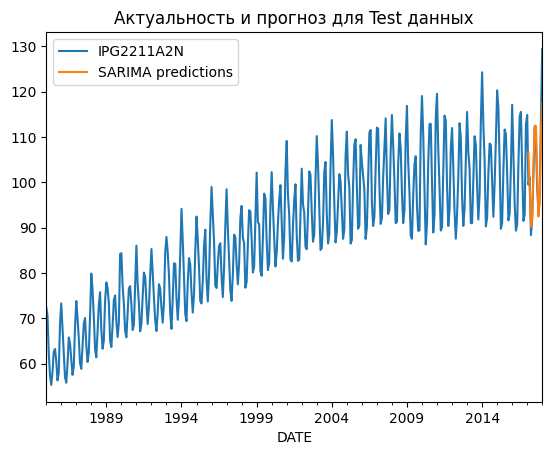

In [72]:
df["IPG2211A2N"].plot(title= title, legend=True)
pred.plot(legend=True)

In [73]:
print(f'RMSE моделей: arima: {mse_arima} sarime: {rmse_arima}')
print(f'MSE моделей: arima: {mse_sarima} sarime: {rmse_sarima}')



RMSE моделей: arima: 40.20841949180201 sarime: 6.34101092033455
MSE моделей: arima: 20.14190657606586 sarime: 4.487973548948998


Модель SARIMA c учетом сезонности показывает лучшие результаты по сравнению с моделью ARIMA не учитывающую сезонные изменения.